In [1]:
from pyspark.sql import window
from pyspark.sql.functions import col, asc, desc, to_timestamp,\
                                  unix_timestamp, from_unixtime
from pyspark.sql.types import StructType, StructField, LongType
import pyspark.sql.functions as func
from pyspark.sql import SparkSession, SQLContext
from pyspark import SparkConf
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA


### We first import the required modules:
 1. our time-series package

In [2]:
from forecast import Forecast, Difference, Predict, SavePredictions
from TimeSeriesFeatureGenerator import LagGather, TrendGather, MovingAverageSmoothing

### Create spark session object

In [3]:
conf = SparkConf()
spark = SparkSession.builder.appName("TimeSeries").master("local")\
                            .config(conf=conf).getOrCreate()



### We have already downloaded Microsoft data from Nasdaq.com
It must be in the same folder as this file

### Reading directly from saved file "msft.csv"

In [4]:
msft_df2 = spark.read.format("csv").option("header","true").option("inferSchema","true").load("./msft.csv")

In [5]:
msft_df2.select("Date","Close").show(2)

+-------------------+-----+
|               Date|Close|
+-------------------+-----+
|1986-03-13 00:00:00| 28.0|
|1986-03-14 00:00:00| 29.0|
+-------------------+-----+
only showing top 2 rows



### Performing Simulations:
SavePredictions(df, timeSeriesCol, regressionType, forecast_days, num_lags, filename, sparksession)
1. df           : the main spark dataframe containing the stock price data
2. timeSeriesCol: time-series used for forecasting, here closing daily-price, "Close" column
3. regressionType: Type of machine-learning algorithm (LinearRegression, DecisionTreeRegression, RandomForestRegression, GBTRegression)
4. forecast_days: future time-step at which forecast is required (integer)
5. num_lags : number of previous time-steps to be used as features (integer)
6. filename : filename for saving the results, two output files are created filenametest.csv and filenametrain.csv
7. sparksession : current spark session

### filename for saving predictions:
Two files are generated: 'filename'+'test.csv' and 'filename+'train.csv'. E.g. if filename given is 'msft' then two files with names 'msfttest.csv' and 'msfttrain.csv' are created


In [6]:
filename = 'LR_MSFT_Predictions'

In [7]:
RMSE_train, RMSE_test = SavePredictions(msft_df2, \
                                        "Close",\
                                        "LinearRegression", \
                                         6, 4, filename,\
                                        spark)

Error statistics summary for LR_MSFT_Predictions 
RMSE for train data:

{'forecast_1day': 2.9274160882660345, 'forecast_2day': 2.927397316554124, 'forecast_3day': 2.9286771832890213, 'forecast_4day': 2.9287216766607944, 'forecast_5day': 2.9291301284947693, 'forecast_6day': 2.9288636961985386}
RMSE for test data:

{'forecast_1day': 0.6513430237517411, 'forecast_2day': 0.6573580611607267, 'forecast_3day': 0.6640604634010516, 'forecast_4day': 0.6697135089988951, 'forecast_5day': 0.6754451137348318, 'forecast_6day': 0.6811314317769687}
Two output files created
Predictions for train data: LR_MSFT_Predictionstrain.csv
Predictions for test data: LR_MSFT_Predictionstest.csv


### Analyzing results

In [8]:
fname_train = filename+'train.csv'
fname_test = filename+'test.csv'
msft_predictions_test = spark.read.format("csv").option("header","true").option("inferSchema","true").load(fname_test)
msft_predictions_train = spark.read.format("csv").option("header","true").option("inferSchema","true").load(fname_train)

In [9]:
msft_predictions_train.select("Date","Close","forecast_1day","actual_1day","forecast_3day","actual_3day").show(5)

+-------------------+-----+------------------+-----------+------------------+-----------+
|               Date|Close|     forecast_1day|actual_1day|     forecast_3day|actual_3day|
+-------------------+-----+------------------+-----------+------------------+-----------+
|1986-03-19 00:00:00|28.25| 28.27127463533312|       27.5|28.281177822431456|       26.0|
|1986-03-20 00:00:00| 27.5| 27.51464106367872|      26.75| 27.51814189659384|       26.5|
|1986-03-21 00:00:00|26.75| 26.76036297242349|       26.0|26.766299072008145|      27.25|
|1986-03-24 00:00:00| 26.0| 26.01252569920295|       26.5| 26.02218357274242|      27.75|
|1986-03-25 00:00:00| 26.5|26.510747283745907|      27.25|26.492494832359977|       27.5|
+-------------------+-----+------------------+-----------+------------------+-----------+
only showing top 5 rows



In [10]:
msft_predictions_test.select("Date","Close","forecast_1day","actual_1day","forecast_3day","actual_3day").show(5)

+-------------------+-----+------------------+-----------+------------------+-----------+
|               Date|Close|     forecast_1day|actual_1day|     forecast_3day|actual_3day|
+-------------------+-----+------------------+-----------+------------------+-----------+
|2008-08-13 00:00:00|27.91|27.911153878591954|      27.91|27.914011611956315|      27.69|
|2008-08-14 00:00:00|27.91|27.912158937684403|      27.81|27.909428267960653|      27.32|
|2008-08-15 00:00:00|27.81| 27.81182253120562|      27.69|27.813743015012445|      27.29|
|2008-08-18 00:00:00|27.69| 27.69044015404964|      27.32|27.691685824709978|      27.18|
|2008-08-19 00:00:00|27.32|27.322487611350713|      27.29| 27.33015185864554|      27.84|
+-------------------+-----+------------------+-----------+------------------+-----------+
only showing top 5 rows



### Plotting results
We convert the data from spark dataframe to pandas dataframe (we can directly read into pandas dataframe as well)

In [11]:
msft_3day_test = msft_predictions_test.select("Date","forecast_3day","actual_3day","Close").toPandas()
msft_3day_train = msft_predictions_train.select("Date","forecast_3day","actual_3day","Close").toPandas()

(array([724276., 725737., 727198., 728659., 730120., 731581., 733042.,
        734503., 735964., 737425.]), <a list of 10 Text xticklabel objects>)

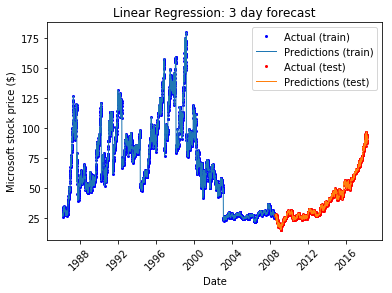

In [12]:
fig = plt.plot(msft_3day_train['Date'],msft_3day_train['actual_3day'], 'bo',\
               msft_3day_train['Date'], msft_3day_train['forecast_3day'],\
               msft_3day_test['Date'], msft_3day_test['actual_3day'],'ro',\
               msft_3day_test['Date'], msft_3day_test['forecast_3day'],\
               markersize = 2, linewidth =1)
plt.xlabel("Date")
plt.ylabel("Microsoft stock price ($)")
plt.legend(['Actual (train)','Predictions (train)', 'Actual (test)', 'Predictions (test)'])
plt.title("Linear Regression: 3 day forecast")
plt.xticks(rotation=45)